<div style="text-align: center;"> <h3>Exploratory Data Analysis</h3>
<h5>Formative Assessment 5</h5>
<h5>April 30, 2025</h5>    
<h5><u>By Romand Lansangan</u></h5>
    </div>
    
---

### Task Overview:
You will analyze a dataset containing 5,000 observations of simulated daily store sales, using Poisson regression to examine how sales counts are influenced by:

* Day of the week

* Promotions

* Holidays

* Store size

### Step 1: Load and Explore the Data (10 points)
Import the dataset into R or Python.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("store_sales_data.csv")
print(df.shape)
df.head()

(5000, 5)


,day_of_week,promo,holiday,store_size,sales_count
0,6,0,0,medium,18
1,3,0,0,medium,13
2,4,0,0,large,24
3,6,1,0,small,16
4,2,0,0,medium,11


Display summary statistics and variable types.

In [3]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day_of_week  5000 non-null   int64 
 1   promo        5000 non-null   int64 
 2   holiday      5000 non-null   int64 
 3   store_size   5000 non-null   object
 4   sales_count  5000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 195.4+ KB
None


,day_of_week,promo,holiday,sales_count
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,2.985400,0.301200,0.095600,13.726400
std,1.990874,0.458825,0.294071,8.677431
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,7.000000
50%,3.000000,0.000000,0.000000,12.000000
75%,5.000000,1.000000,0.000000,18.000000
max,6.000000,1.000000,1.000000,61.000000


### Missing Data

In [21]:
df.isna().sum()

day_of_week       0
promo             0
holiday           0
store_size        0
sales_count       0
store_size_map    0
dtype: int64

#### Distribution of sales_count

Text(0.5, 1.0, 'PDF of `sales_count`')

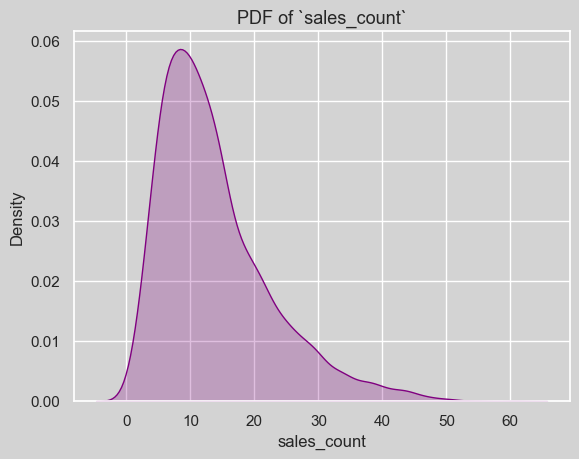

In [4]:
sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'

sns.kdeplot(df['sales_count'], fill=True, color="purple")
plt.title("PDF of `sales_count`", size=13)

#### Frequency of each store_size

Text(0, 0.5, 'Frequency')

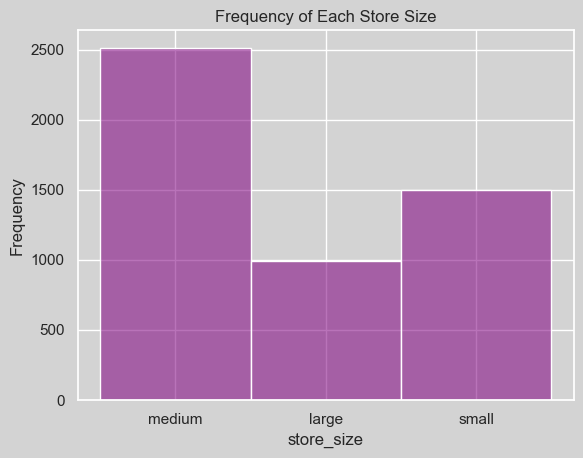

In [5]:
sns.histplot(df.store_size, color="Purple", alpha=0.55)
plt.title("Frequency of Each Store Size")
plt.ylabel("Frequency")

#### Proportion of days with promo and holiday

In [6]:
proportion = df.groupby(['promo', 'holiday']).count()['day_of_week'] / len(df)
label_map = {
    (0, 0): 'No Promo, No Holiday',
    (0, 1): 'No Promo, Holiday',
    (1, 0): 'Promo, No Holiday',
    (1, 1): 'Promo, Holiday'
}

new_index_labels = [label_map[combo] for combo in proportion.index]
proportion.index = new_index_labels
proportion

No Promo, No Holiday    0.6320
No Promo, Holiday       0.0668
Promo, No Holiday       0.2724
Promo, Holiday          0.0288
Name: day_of_week, dtype: float64

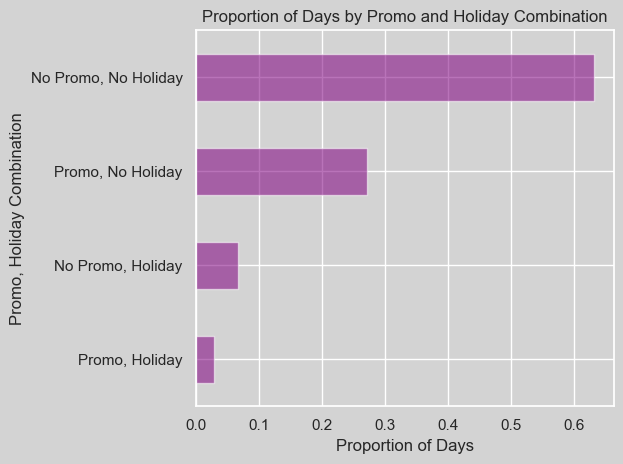

In [7]:
proportion.sort_values(ascending=True).plot(kind="barh", color="Purple", alpha=0.55)

plt.xlabel("Proportion of Days")
plt.ylabel("Promo, Holiday Combination")
plt.title("Proportion of Days by Promo and Holiday Combination")

plt.tight_layout()
plt.show()

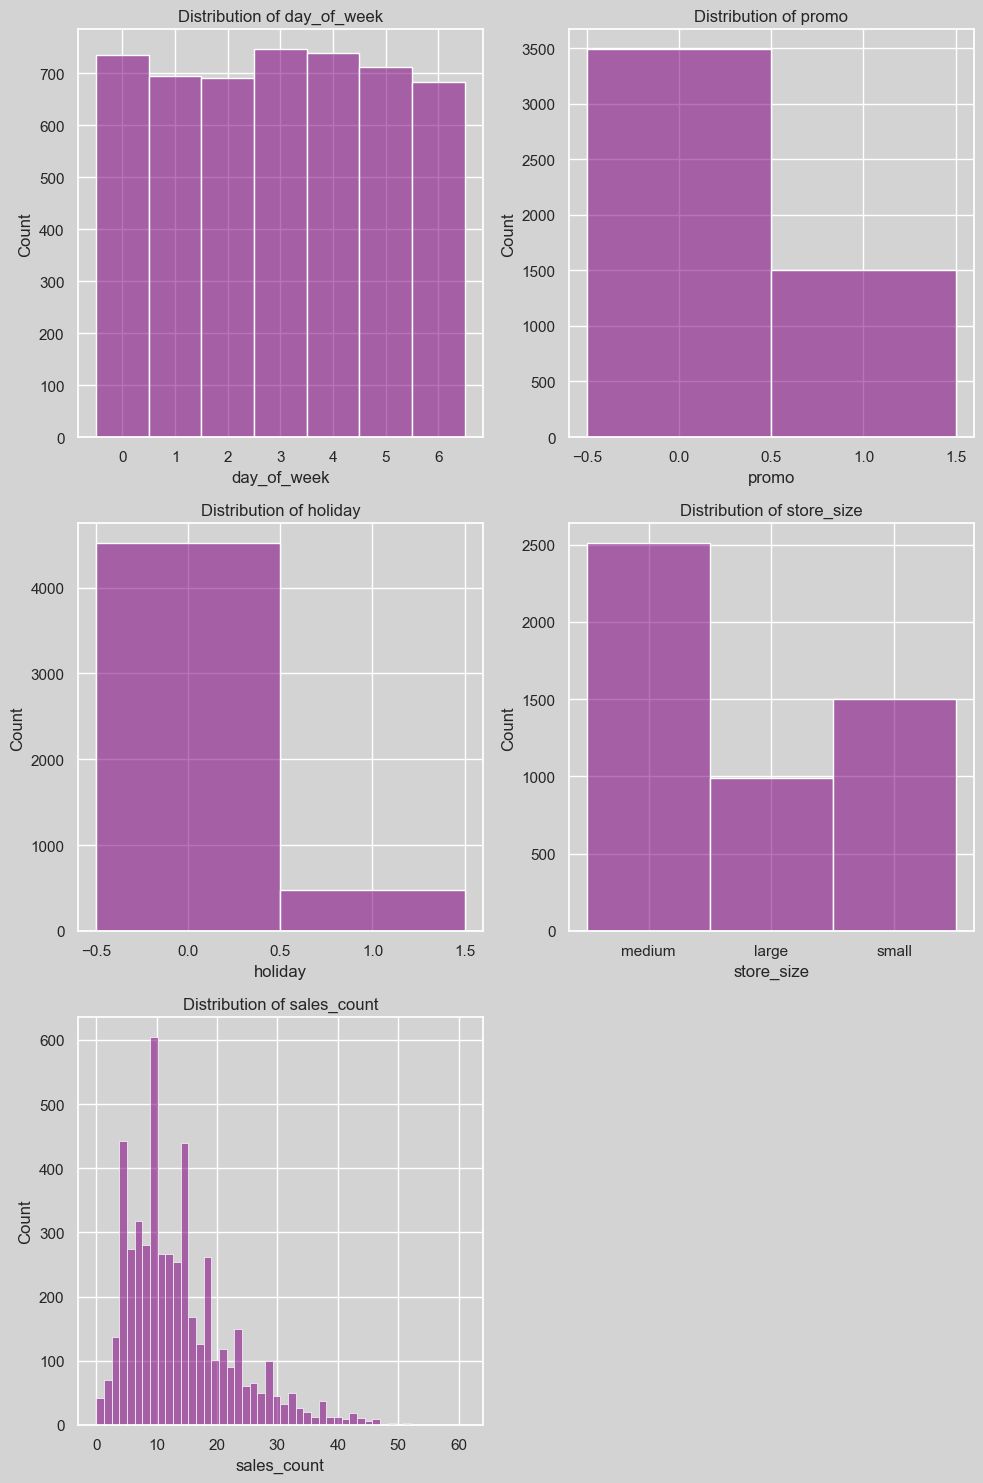

In [8]:
cols = df.columns

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,15))

axes = axes.flatten()

for ind, col in enumerate(cols):
    sns.histplot(
        df[col],
        ax=axes[ind],
        discrete=col != "sales_count",
        color="Purple",
        alpha=0.55
    )
    axes[ind].set_title(f"Distribution of {col}")

plt.delaxes(axes[-1])
plt.tight_layout()

### Correlation

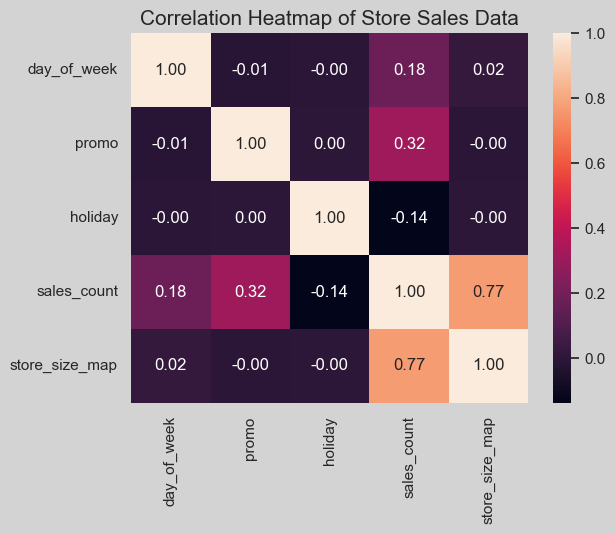

In [9]:
mapping = {
    "small" : 1,
    "medium" : 2,
    "large" : 3
}

df['store_size_map'] = df['store_size'].map(mapping)

sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    fmt = ".2f"
)

plt.title("Correlation Heatmap of Store Sales Data", size=15);

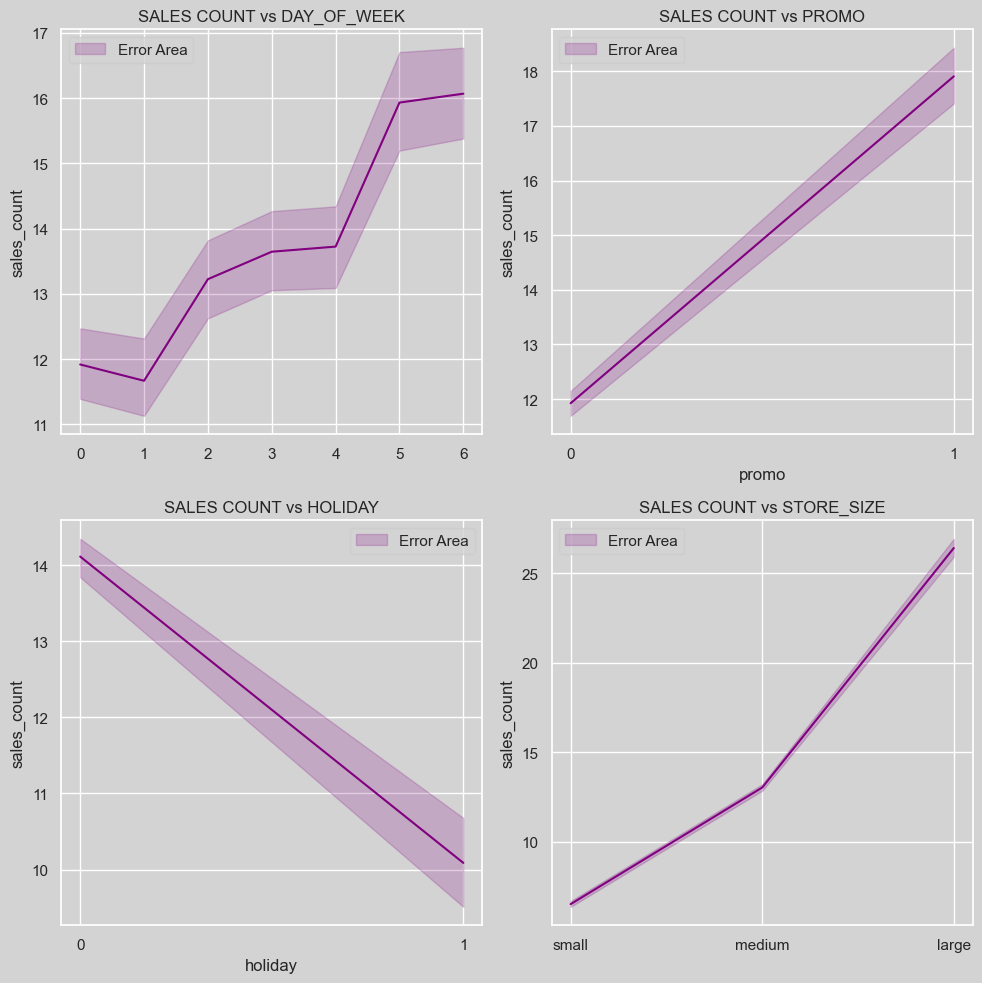

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axes = axes.flatten()

for ind, col in enumerate(df.drop(columns=["sales_count", 'store_size_map']).columns):
    if col == "store_size":
        plot = pd.Categorical(df[col], categories=["small", "medium", "large"])
    elif col in ["promo", 'holiday']:
        plot = df[col].astype(str)
    else:
        plot=pd.Categorical(df[col], ordered=True)

    sns.lineplot(
        df, 
        x=plot,
        y=df['sales_count'],
        ax=axes[ind],
        color="purple",
        err_kws={"label": "Error Area"}
    )
    axes[ind].set_title(f"SALES COUNT vs {col.upper()}")

plt.legend()
plt.tight_layout()

A pattern can be clearly discerned from each variables. 

* `day_of_the_week` - the sales increase as the weekend comes.
* `promo` - more sales occured during promo periods.
* `holiday` - surprisingly, being in holiday decreases the sales. Maybe it's becasuse some stores are closed for holidays (?)[I checked, that's not the case]
* `store_size` - larger stores tend to get more sales.

### Step 2: Fit a Poisson Regression Model (30 points)

Fit a Poisson regression model with sales_count as the outcome.



In [11]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print("Train size:", df_train.shape)
print("Test size:", df_test.shape)

Train size: (4000, 6)
Test size: (1000, 6)


In [12]:
mean = df_test['sales_count'].mean()

baseline = abs(df_test['sales_count'] - mean).mean()

print("Baseline:", baseline)

Baseline: 6.480272000000001


In [26]:
import statsmodels.formula.api as smf
import statsmodels.api as sm


formula = 'sales_count ~ ' + " + ".join(df_train.drop(columns=["sales_count", 'store_size']).columns)
model = smf.glm(formula=formula, data=df_train, family=sm.families.Poisson())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            sales_count   No. Observations:                 4000
Model:                            GLM   Df Residuals:                     3995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10638.
Date:                Wed, 07 May 2025   Deviance:                       4169.9
Time:                        12:13:19   Pearson chi2:                 4.11e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9831
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9104      0.016     55.637      0.000       0.878       0.942
day_of_week        0.0502      0.002     23.444      0.000       0.046       0.054
promo              0.4144      0.009     47.728      0.000       0.397       0.431
holiday           -0.3370      0.017    -20.258      0.000      -0.370      -0.304
store_size_map     0.6950      0.006    111.585      0.000       0.683       0.707
==================================================================================
"""

In [23]:
overdispersion = model.deviance / model.df_resid

if overdispersion > 1.3:
    print(f"Overdispersion occurs\nvalue = {overdispersion}")
else:
    print(f"Overdispersion did not occur\nvalue = {overdispersion}")

Overdispersion did not occur
value = 1.0437758341923553


Overdispersion exists if $\frac{Resid \ Dev}{df} > 1$. However, we will still be good if the proprotion is around 1.3. Since the proportion is close to 1 in our model, overdispersion does not exists in this case. Meaning $Var(Y) = E(Y)$. If it did we could just resort to **Negative Binomial Regression** that is a very simillar to poisson except but allows for mean to be greater than variance because of the presence of another term ($Var(Y) = E(Y) + \alpha E(Y)$). Notice how as $\alpha$ approaches to $0$, the **Negative Binomial Regression** becomes **Poisson Distribution**. 

However, just for the sake of it, let us also fit a **Negative Binomial Regression** to the data and compare the results.

In [ ]:
formula = 'sales_count ~ ' + " + ".join(df_train.drop(columns=["sales_count", 'store_size']).columns)
model_bi = smf.glm(formula=formula, data=df_train, family=sm.families.NegativeBinomial())
model_bi = model_bi.fit()
model_bi.summary()

d:\Anaconda\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            sales_count   No. Observations:                 4000
Model:                            GLM   Df Residuals:                     3995
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14096.
Date:                Wed, 07 May 2025   Deviance:                       397.07
Time:                        12:13:16   Pearson chi2:                     355.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2410
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9058      0.056     16.259      0.000       0.797       1.015
day_of_week        0.0506      0.008      6.068      0.000       0.034       0.067
promo              0.4156      0.036     11.628      0.000       0.346       0.486
holiday           -0.3382      0.057     -5.902      0.000      -0.450      -0.226
store_size_map     0.6964      0.024     29.388      0.000       0.650       0.743
==================================================================================
"""

In [36]:
print("Poisson Regression Deviance:", model.deviance)
print("Negative Binomial Regression Deviance:", model_bi.deviance)

Poisson Regression Deviance: 4169.884457598459
Negative Binomial Regression Deviance: 397.0656678941127


In [37]:
print("Poisson Regression AIC:", model.aic)
print("Negative Binomial Regression AIC:", model_bi.aic)

Poisson Regression AIC: 21286.356513906507
Negative Binomial Regression AIC: 28201.925694591926


Although, Poisson Regression have less AIC than Negative Binomial Regression, the difference in deviance is too massive. With the aforementioned diagnostic, we can say that Negative Binomial Regression is a better model. The only reason we started with **Poisson Distribution** is it's much more simple and we don't want unnecesary parameters ($\alpha$) if not needed. With that being said, let's stil use the **Poisson Distribution** since its simpler and doesn't violate any assumptions.

---
## Evaluation

In [38]:
y_pred = model.predict(df_train)
y_train = df_train['sales_count']
resid_train = y_train- y_pred

mae = abs(resid_train).mean()

print("Baseline:", baseline)
print("Mean abosolute error:", mae)

Baseline: 6.480272000000001
Mean abosolute error: 2.9011385019491946


In [39]:
y_pred = model.predict(df_test)
y_test = df_test['sales_count']
resid_test = y_test- y_pred

mae = abs(resid_test).mean()

print("Baseline:", baseline)
print("Mean abosolute error:", mae)

Baseline: 6.480272000000001
Mean abosolute error: 2.8154642638195444


The *Mean Absolute Error* of train and test set brought forth a significantly less error than the baseline model. Also, the MAE of train and test set doesn't stray away from one another. So we can assert that the model generilize well.

In [42]:
sample = {
    "store_size_map" : 1,
    "day_of_week" : 0,
    "promo" : 1,
    "holiday" : 0
}

df_sample = pd.DataFrame([sample])
df_sample

,store_size_map,day_of_week,promo,holiday
0,1,0,1,0


In [43]:
store_1 = model.predict(df_sample)
store_1

0    7.536278
dtype: float64

In [18]:
sample = {
    "store_size_map" : 2,
    "day_of_week" : 6,
    "promo" : 0,
    "holiday" : 0
}
df_sample = pd.DataFrame([sample])
df_sample

,store_size_map,day_of_week,promo,holiday
0,2,6,0,0


In [40]:
store_2 = model.predict(df_sample)
store_2

0    13.483823
dtype: float64

In [44]:
store_2 - store_1

0    5.947545
dtype: float64

On average (by Poisson Distribution), a small store on non-holiday monday with promo will have `sales_count` of **5.947545 less** than a large store during sataurday without promo.

In [ ]:
model.params

Intercept         0.910385
day_of_week       0.050194
promo             0.414374
holiday          -0.336992
store_size_map    0.694969
dtype: float64

## Reflection

The *Poisson Regression* model fits the data really well. Given a baseline of 6.480272000000001, an MAE of 2.9011385019491946 for train set and 2.8154642638195444 `sales_count` for test set indicates that the model have performed significantly better than the baseline and have thus fit the data really well. With $\text{Dispersion Parameter} = 1.0437758341923553$, the model doesn't violate the equal mean and variance assumption. A *Negative Binomial Regression* was also fitted and brought forth a better model than the earlier one. However, simplicity is preferred and since there's no assumption violation, the final model was chosen to be the *Poisson Regression*. This sheds light on the preference of simplicity over complexity, especially in the face of relatively simillar results between two models.

All coefficients are statistically significant. Meaning, they are not zero. The most important coeficient, as it turned out, was `store_size` with 0.694969.  This implies that a larger store tend to sell more than the smaller stores. The second most important is `day_of_the_week` with 0.050194 which make sense because people tend to shop more as the weekend comes close. Being in `promo` also helps with sales by about 0.414374. Surprisingly enough, `holiday` resulted to a negative coeficient of -0.336992. This might imply that the product isn't a priority during the holidays.

One limitation for this type of model is that real world  `sales_count` are notoriously susciptible to overdispersion. This can be caused by unseen factors like economic contexts. If overdispersion is present, true variabily of `sales_count`and will lead to unreliable coefficient results. Applying *Poisson Regression* in real world scenario (and future cases) would require ongoing monitoring for overdispersion and potentially switching to a model like *Negative Binomial* if it arises, despite the initial finding of no overdispersion in the training data.